<h2>Considerações iniciais</h2>
<div>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbspA função evaluate_model foi projetada para realizar uma avaliação abrangente dos métodos de machine learning, utilizando técnicas de validação cruzada para garantir resultados confiáveis e robustos. A principal função dessa avaliação é calcular métricas de desempenho como acurácia, precisão, recall, F1-Score e a matriz de confusão, em diferentes divisões dos dados, conhecidas como folds. Cada uma dessas métricas é calculada para cada fold, e ao final, são computadas as médias, proporcionando uma visão geral e representativa do desempenho do modelo. Esse processo ajuda a mitigar a influência de variações ou outliers que possam estar presentes em qualquer subdivisão específica dos dados, garantindo que a avaliação final seja estável e confiável.
</div>
<div>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbspO uso de médias nas métricas de avaliação foi uma escolha na função evaluate_model, pois permite uma avaliação mais robusta e representativa do desempenho dos modelos. Ao calcular as métricas para cada fold e, posteriormente, calcular suas médias, a função garante que o desempenho reportado não seja influenciado por divisões específicas dos dados que possam conter particularidades que distorçam a avaliação. Isso é particularmente importante nesse cenário de validação cruzada, onde o objetivo é obter uma estimativa precisa e generalizável do desempenho do modelo em dados não vistos. Além disso, o cálculo de médias ponderadas para métricas como precisão e recall considera o desbalanceamento de classes, proporcionando uma avaliação mais justa e precisa em situações onde algumas classes são mais prevalentes do que outras.
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report,f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score

In [2]:
try:
   df = pd.read_csv('koi_data.csv')
except:
   print("Falha ao abrir o banco de dados!")
else:
   print("Banco de dados aberto!")


Banco de dados aberto!


In [3]:
X = df.iloc[:, 2:].values  # Todas as colunas exceto a primeira (KOI ID) e a segunda (label)
Y = df.iloc[:, 1].values   # Segunda coluna (label) Koi Disposition, Confirmed, False Positive
all_metrics=[]
all_confusion_matrix=[]
num_classes = len(np.unique(Y))  # Calcula o número de classes com base nos dados

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#Aqui, shuffle=True embaralha os dados antes de dividí-los, e random_state=42 garante que os resultados sejam reprodutíveis.

In [ ]:
def evaluate_model(model, X, Y, kf,model_name):
    y_true = []
    y_pred = []
    accuracies=[]
    precisions = []
    recalls = []
    f1_scores = []
    cm=np.zeros((num_classes, num_classes))
    for train_index, test_index in kf.split(X):
       
         X_train, X_test = X[train_index], X[test_index]
         Y_train, Y_test = Y[train_index], Y[test_index]
        
         pipeline = make_pipeline(StandardScaler(), model)
         pipeline.fit(X_train, Y_train)
         
         Y_pred = pipeline.predict(X_test)
         #y_true.extend(Y_test)# 
         #y_pred.extend(Y_pred)
        
         accuracy = accuracy_score(Y_test, Y_pred)
         aux_cm=confusion_matrix(Y_test,Y_pred)
         cm+=aux_cm
  
         precision = precision_score(Y_test, Y_pred, average='weighted')
         recall = recall_score(Y_test, Y_pred, average='weighted')
         f1 = f1_score(Y_test, Y_pred, average='weighted')
        
         accuracies.append(accuracy)
         precisions.append(precision)
         recalls.append(recall)
         f1_scores.append(f1)
    

    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    mean_f1 = sum(f1_scores) / len(f1_scores)
    all_confusion_matrix.append(cm)
    all_metrics.append((str(model_name), round(mean_accuracy, 4), round(mean_precision, 4), round(mean_recall, 4), round(mean_f1, 4)))


In [47]:
def naive_bayes_experiment(X, Y, kf):
    model = GaussianNB()
    model_name="Naive Bayes"
    evaluate_model(model, X, Y, kf,model_name)  # Avalia o modelo com matriz de confusão e relatório de métricas
    mean_accuracy = all_metrics[-1][1]
    return mean_accuracy

In [8]:
def decision_tree_experiment(X, Y, kf):
    depths = [None, 5, 10, 15, 20]
    dte_accuracies = []
    model_name="Decision Tree with Depth= "
    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        evaluate_model(model, X, Y, kf,model_name+str(depth))  # Avalia o modelo com matriz de confusão e relatório de métricas
        dte_accuracies.append(all_metrics[-1][1])
       
    plt.plot(depths, dte_accuracies, marker='o')
    plt.xlabel('Profundidade Máxima')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto da Profundidade Máxima na Acurácia do Decision Tree')
    plt.grid(True)
    plt.show()

In [9]:
def svm_experiment(X, Y, kf):
    kernels = ['linear', 'rbf']
    svm_accuracies = []
    model_name="SVM with Kernel "
    for kernel in kernels:
        model = SVC(kernel=kernel, random_state=42)
        evaluate_model(model, X, Y, kf,model_name+str(kernel))  # Avalia o modelo com matriz de confusão e relatório de métricas
        svm_accuracies.append(all_metrics[-1][1])
       
    df_results = pd.DataFrame({
        'Kernel': kernels,
        'Acurácia Média': svm_accuracies
    })

    # Plota a tabela usando matplotlib
    fig, ax = plt.subplots(figsize=(6, 2))  # Ajuste o tamanho da figura conforme necessário
    ax.axis('tight')
    ax.axis('off')

    title = 'Comparação de Kernels do SVM'
    plt.title(title, fontsize=14, pad=20)

    table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Ajusta o tamanho da célula

    plt.show()

In [10]:
def knn_experiment(X, Y, kf):
    k_values = [1, 3, 5, 7, 9, 11]
    knn_accuracies = []
    model_name="KNN with k_value = "
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        evaluate_model(model, X, Y, kf,model_name+str(k))  # Avalia o modelo com matriz de confusão e relatório de métricas
        knn_accuracies.append(all_metrics[-1][1])
        #pipeline = make_pipeline(StandardScaler(), model)
        #scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        #accuracies.append(scores.mean())

    plt.plot(k_values, knn_accuracies, marker='o')
    plt.xlabel('Número de Vizinhos (k)')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Vizinhos na Acurácia do k-NN')
    plt.grid(True)
    plt.show()

In [11]:
def random_forest_experiment(X, Y, kf):
    n_trees = [10, 50, 100, 200, 300]
    rf_accuracies = []
    model_name="Random Forest with N_Trees = "
    for n in n_trees:
        model = RandomForestClassifier(n_estimators=n, random_state=42)
        evaluate_model(model, X, Y, kf,model_name+str(n))  # Avalia o modelo com matriz de confusão e relatório de métricas
        rf_accuracies.append(all_metrics[-1][1])
        
    plt.plot(n_trees, rf_accuracies, marker='o')
    plt.xlabel('Número de Árvores')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Árvores na Acurácia do Random Forest')
    plt.grid(True)
    plt.show()

In [12]:
def gradient_boosting_experiment(X, Y, kf):
    n_estimators = [10, 50, 100, 200, 300]
    gb_accuracies = []
    model_name = "Gradient Boosting with N_Estimators = "
    
    for n in n_estimators:
        model = GradientBoostingClassifier(n_estimators=n, random_state=42)
        evaluate_model(model, X, Y, kf, model_name + str(n))  # Avalia o modelo com matriz de confusão e relatório de métricas
        gb_accuracies.append(all_metrics[-1][1])
    
    # Plotando o gráfico
    plt.plot(n_estimators, gb_accuracies, marker='o')
    plt.xlabel('Número de Iterações (Estimators)')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Iterações no Gradient Boosting')
    plt.grid(True)
    plt.show()

In [13]:
def mlp_experiment(X, Y, kf):
    activations = ['identity', 'logistic', 'tanh', 'relu']
    mlp_accuracies = []
    model_name="MLP with activation = "
    for activation in activations:
        model = MLPClassifier(
            hidden_layer_sizes=(25,),
            activation=activation,
            solver='adam',
            learning_rate_init=0.003,
            max_iter=1000,
            random_state=42
        )
        evaluate_model(model, X, Y, kf,model_name+str(activation))  # Avalia o modelo com matriz de confusão e relatório de métricas
        mlp_accuracies.append(all_metrics[-1][1])
    df_results = pd.DataFrame({
        'Função de Ativação': activations,
        'Acurácia Média': mlp_accuracies
    })

    # Plota a tabela usando matplotlib
    fig, ax = plt.subplots(figsize=(8, 3))  # Ajuste o tamanho da figura conforme necessário
    ax.axis('tight')
    ax.axis('off')

    # Adiciona o título da tabela
    title = 'Comparação entre Funções de Ativação do MLP'
    plt.title(title, fontsize=14, pad=20)

    # Cria a tabela
    table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Ajusta o tamanho da célula

    plt.show()

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

def plotMetrics(metric_name):
    # Cria o DataFrame apenas com as colunas de Modelo e Acurácia Média
    df = pd.DataFrame(all_metrics, columns=['Modelo', 'Acurácia Média', 'Precisão Média', 'Revocação Média', 'F1-Score Médio'])
    
    # Pegar os nomes dos modelos e as acurácias
    modelos = df['Modelo']
    metrics = df[metric_name]
    
    # Plotar o gráfico de dispersão (scatter plot) vertical
    plt.figure(figsize=(10, 6))
    plt.scatter(metrics, modelos, color='blue', marker='o')
    
    # Adicionar título e rótulos aos eixos
    plt.title(str(metric_name)+' por Modelo', fontsize=16)
    plt.xlabel(str(metric_name), fontsize=12)
    plt.ylabel('Modelo', fontsize=12)
    
    # Adicionar legendas aos pontos
    for i, (modelo, metric) in enumerate(zip(modelos, metrics)):
        plt.text(metric, modelo, f'{metric:.4f}', fontsize=10, ha='left', va='center')
    
    # Mostrar a grade para facilitar a visualização dos pontos
    plt.grid(True)
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

In [15]:
def plotAllMetrics():
    metrics=['Acurácia Média', 'Precisão Média', 'Revocação Média', 'F1-Score Médio']
    for metric in metrics:
        plotMetrics(metric)

In [16]:
def plotAllMetricsTable():
    df = pd.DataFrame(all_metrics, columns=['Modelo', 'Acurácia Média', 'Precisão Média', 'Revocação Média', 'F1-Score Médio'])
    
    # Calcula o tamanho da figura com base no número de colunas e linhas
    n_rows, n_cols = df.shape
    fig_width = n_cols * 2  # Largura baseada no número de colunas
    fig_height = n_rows * 0.5 + 1  # Altura baseada no número de linhas

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('tight')
    ax.axis('off')

    # Cria a tabela
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Substitua 12 pelo tamanho de fonte desejado
    table.auto_set_column_width(list(range(len(df.columns))))
    plt.show()


In [17]:
def plotAllConfusionmatrix():
    # Seleciona a matriz de confusão pelo índice i
    for i in range(len(all_metrics)):
        model_name=all_metrics[i][0]
        cm = all_confusion_matrix[i]
        
        # Cria uma figura e um eixo
        fig, ax = plt.subplots()
        
        # Plota a matriz de confusão como um mapa de calor
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=ax, cbar=False, 
                    xticklabels=['Confirmed', 'False Positive'], yticklabels=['Confirmed', 'False Positive'])
        
        # Configura os rótulos e o título
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')
        ax.set_title('Matriz de Confusão -'+ str(model_name))  # Título opcionalmente pode incluir o índice do modelo
        
        # Exibe o gráfico
        plt.show()

<h2>Disposição dos dados </h2>
<p>
    A contagem inicial da base de dados apresentada na tabela mostra a distribuição das classes para a variável 
    <strong>koi_disposition</strong>, que contém as categorias "FALSE POSITIVE" e "CONFIRMED". Especificamente, temos:
</p>

<ul>
    <li><strong>FALSE POSITIVE</strong>: 3.098 instâncias</li>
    <li><strong>CONFIRMED</strong>: 2.104 instâncias</li>
</ul>

<p>
    Essa distribuição sugere que a base de dados é moderadamente desbalanceada, com uma quantidade maior de exemplos rotulados como 
    "FALSE POSITIVE" em comparação com "CONFIRMED". Em termos percentuais, aproximadamente 59,6% das instâncias pertencem à classe 
    "FALSE POSITIVE" e 40,4% à classe "CONFIRMED".
</p>

In [18]:
#Tipo de dado de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        5202 non-null   object 
 1   koi_disposition   5202 non-null   object 
 2   koi_period        5202 non-null   float64
 3   koi_impact        5202 non-null   float64
 4   koi_duration      5202 non-null   float64
 5   koi_depth         5202 non-null   float64
 6   koi_ror           5202 non-null   float64
 7   koi_srho          5202 non-null   float64
 8   koi_prad          5202 non-null   float64
 9   koi_sma           5202 non-null   float64
 10  koi_incl          5202 non-null   float64
 11  koi_teq           5202 non-null   float64
 12  koi_insol         5202 non-null   float64
 13  koi_dor           5202 non-null   float64
 14  koi_max_sngle_ev  5202 non-null   float64
 15  koi_max_mult_ev   5202 non-null   float64
 16  koi_model_snr     5202 non-null   float64


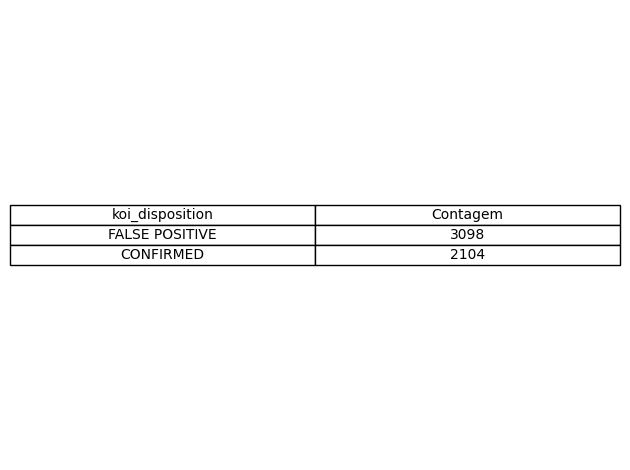

In [19]:
#Contagem de quantos CONFIRMED E FALSE POSITIVE tem NO DF

contagens = df.koi_disposition.value_counts()

# Criando a figura e o eixo
fig, ax = plt.subplots()

# Ocultando o eixo (opcional)
ax.axis('off')
ax.axis('tight')

# Convertendo para DataFrame para criar a tabela
table_data = contagens.reset_index()
table_data.columns = ['koi_disposition', 'Contagem']

# Criando a tabela
ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Ajustando o layout
fig.tight_layout()

# Exibindo a tabela
plt.show()

<h2>Análise de Modelos de Classificação</h2>

In [20]:
naive_bayes_experiment(X, Y, kf)
 

0.9166

<h3>Decision Tree</h3>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Uma árvore de decisão é um modelo de machine learning que faz previsões através de uma estrutura em forma de árvore, onde cada nó interno representa uma condição baseada em uma característica dos dados, e cada nó folha representa uma classe ou valor predito. O algoritmo divide os dados recursivamente em subconjuntos mais homogêneos, criando ramificações até que um critério de parada seja alcançado, como a profundidade máxima da árvore.</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp;A árvore de decisão é um modelo que se torna mais complexo à medida que a profundidade aumenta, permitindo que o modelo capture mais detalhes dos dados de treinamento. No entanto, essa complexidade extra pode levar ao <strong>overfitting</strong>, onde o modelo se ajusta demais aos dados de treinamento, incluindo ruído ou padrões irrelevantes. Como resultado, o modelo perde a capacidade de generalizar para novos dados, o que é evidenciado pela diminuição da acurácia média.</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp;No gráfico, percebe-se que a acurácia média é maior quando a profundidade da árvore é menor (em torno de 6 a 8). Isso sugere que, neste intervalo, a árvore está equilibrada: é suficientemente profunda para capturar os padrões importantes, mas não tão profunda a ponto de overfittar os dados. Conforme a profundidade aumenta para além de 10, a acurácia média começa a cair. Isso indica que o modelo começa a overfittar os dados de treinamento, o que prejudica o desempenho em novos dados.</p>

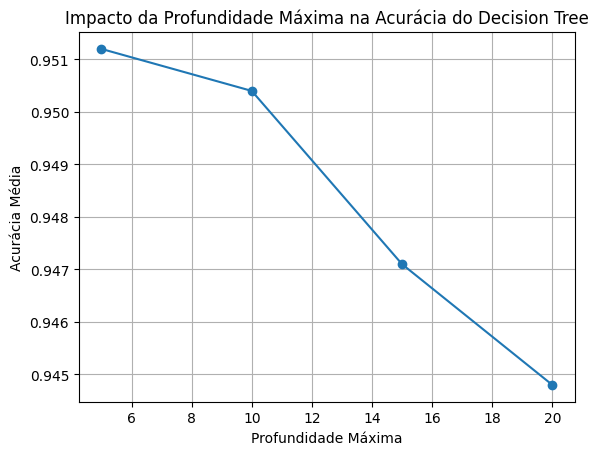

In [21]:
decision_tree_experiment(X, Y, kf)
   

<h3>Support Vector Machine (SVM)</h3>

<p>&nbsp;&nbsp;&nbsp;&nbsp;O algoritmo Support Vector Machine (SVM) trabalha encontrando o hiperplano que melhor separa as diferentes classes em um espaço de alta dimensão. Dependendo do tipo de kernel escolhido, o SVM pode lidar com dados que não são linearmente separáveis, mapeando-os para uma dimensão superior onde uma separação linear seja possível.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp;Na tabela apresentada, temos a comparação de dois kernels do SVM: o kernel linear e o kernel radial basis function (RBF). O kernel linear aplica uma separação linear direta entre as classes, enquanto o kernel RBF transforma os dados em uma dimensão superior para encontrar uma separação mais complexa.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp;Conforme os resultados da tabela, observa-se que o kernel linear obteve uma acurácia média de 0.9506, superior à acurácia média de 0.9358 obtida pelo kernel RBF. Isso indica que, para este conjunto de dados específico, o kernel linear foi mais eficaz em classificar corretamente os exemplos. Embora o kernel RBF seja geralmente útil para capturar padrões mais complexos, neste caso específico, o kernel linear conseguiu capturar a essência dos dados de forma mais eficiente.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbspEssa análise sugere que, dependendo das características dos dados, o kernel linear pode ser uma escolha mais adequada, especialmente quando as classes são aproximadamente linearmente separáveis.Nesse caso, o uso do kernel RBF pode não ter trazido benefícios adicionais significativos, resultando em uma ligeira queda na acurácia.
    </p>

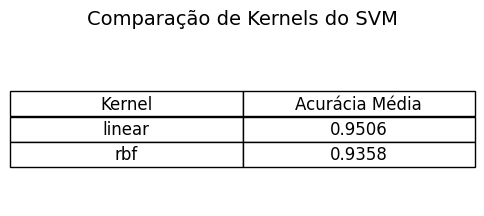

In [22]:
svm_experiment(X, Y, kf)
   

<h3>k-Nearest Neighbors (k-NN)</h3>

<p>&nbsp;&nbsp;&nbsp;&nbsp
        O algoritmo k-Nearest Neighbors (k-NN) é um método de aprendizado supervisionado que classifica um ponto de dados com base nos rótulos dos k pontos de dados mais próximos. O desempenho do k-NN é altamente dependente do valor de k escolhido, que representa o número de vizinhos considerados no processo de decisão.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp
        O gráfico apresentado mostra a relação entre o número de vizinhos (k) e a acurácia média do modelo. Observa-se que, à medida que o valor de k aumenta, a acurácia média do modelo também varia. Inicialmente, para valores baixos de k, a acurácia média aumenta, atingindo um pico em torno de k = 4. Este comportamento indica que para este conjunto de dados, considerar 4 vizinhos é o ponto ideal para maximizar a acurácia.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp
        No entanto, conforme k continua a aumentar além de 4, a acurácia começa a diminuir gradualmente. Este declínio pode ser explicado pelo fato de que, com um número muito grande de vizinhos, o modelo pode começar a incluir vizinhos que não são tão relevantes, levando a uma suavização excessiva das fronteiras de decisão e, consequentemente, a uma piora na performance do modelo.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp
        Portanto, com base no gráfico, podemos concluir que o valor ideal de k para este problema específico é em torno de 4. Usar um valor muito alto de k, como 10, pode resultar em uma queda significativa na acurácia do modelo, evidenciando a importância da escolha adequada desse hiperparâmetro.
    </p>

knn_experiment(X, Y, kf)

In [ ]:
<h3>Random Forest </h3>

<p>&nbsp;&nbsp;&nbsp;&nbsp
        O Random Forest utiliza múltiplas árvores de decisão para realizar classificações ou regressões. A ideia principal é combinar as previsões de várias árvores para melhorar a robustez e a precisão do modelo. Um dos hiperparâmetros críticos desse modelo é o número de árvores na floresta, que pode influenciar significativamente seu desempenho.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp
        O gráfico apresentado ilustra a relação entre o número de árvores na floresta e a acurácia média do modelo. Observa-se que, à medida que o número de árvores aumenta, a acurácia também melhora, mas até certo ponto. Inicialmente, ao adicionar mais árvores, a acurácia média cresce rapidamente, atingindo um valor próximo de 0.970 quando o número de árvores chega a 200.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp
        No entanto, após atingir o pico com 200 árvores, o aumento adicional no número de árvores não resulta em melhorias significativas na acurácia. De fato, o gráfico mostra uma leve queda na acurácia ao aumentar para 300 árvores, o que sugere que, além de um certo ponto, adicionar mais árvores pode levar a um desempenho estável ou até ligeiramente inferior devido a possíveis sobreajustes ou redundâncias no modelo.
    </p>
    <p>&nbsp;&nbsp;&nbsp;&nbsp
        Portanto, com base no gráfico, podemos concluir que o número ideal de árvores para este problema específico está em torno de 200. Embora o aumento do número de árvores inicialmente melhore a acurácia, passar deste ponto não traz benefícios adicionais significativos e pode até prejudicar o desempenho.
    </p>

random_forest_experiment(X, Y, kf)

<h3>Gradient Tree Boosting</h3>
<p>&nbsp;&nbsp;&nbsp;&nbsp
       O Gradient Boosting é um algoritmo de aprendizado de máquina que combina múltiplos modelos fracos (geralmente árvores de decisão) para criar um modelo forte e preciso. Ele funciona adicionando modelos sequencialmente, com cada novo modelo tentando corrigir os erros do modelo anterior. O número de iterações, ou estimators, representa a quantidade de modelos que são combinados.
</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp
Analisando o gráfico, observamos um aumento gradual na acurácia média do modelo à medida que o número de iterações aumenta, até atingir um platô em torno de 200 iterações. Isso indica que, até certo ponto, adicionar mais modelos ao ensemble melhora a capacidade do modelo de generalizar para novos dados. 
   
</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp
 No entanto, após 200 iterações, o aumento na acurácia se torna marginal, sugerindo que adicionar mais modelos além desse ponto não traz benefícios significativos e pode até levar a overfitting (quando o modelo se ajusta demais aos dados de treinamento, perdendo a capacidade de generalizar).
 </p>

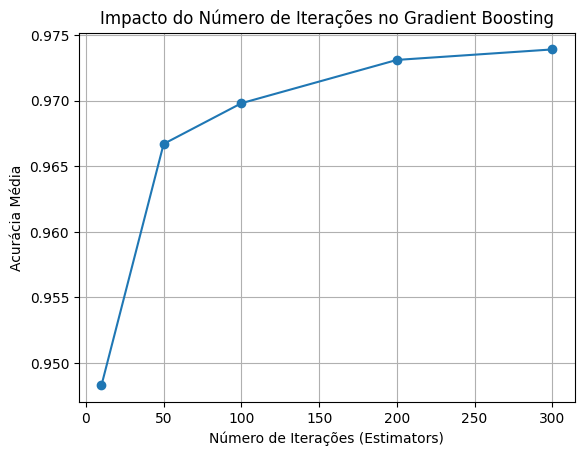

In [25]:
gradient_boosting_experiment(X, Y, kf)

<h3>Multilayer Perceptron (MLP)</h3>

<p>&nbsp;&nbsp;&nbsp;&nbsp

O Classificador MLP (Perceptron Multicamadas) é uma rede neural artificial que se inspira na estrutura e funcionamento do cérebro humano. Ele é composto por múltiplas camadas de neurônios interconectados, onde cada neurônio processa informações e as transmite para os neurônios da camada seguinte.
    
</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp
O processo de aprendizado de um MLP envolve a propagação de dados de entrada através da rede, o cálculo do erro entre a saída prevista e a saída real, e a retropropagação desse erro para ajustar os pesos sinápticos. As funções de ativação, como a ReLU, sigmoid e tanh, introduzem não-linearidade na rede, permitindo que ela aprenda padrões complexos.    
</p>


<p>&nbsp;&nbsp;&nbsp;&nbsp
As funções sigmoid e tanh introduzem não-linearidade, mas sofrem do problema de saturação para valores de entrada muito grandes ou muito pequenos. Essa saturação pode desacelerar o treinamento e limitar a capacidade da rede de aprender representações complexas.
</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp
A função ReLU (Unidade Linear Retificada) se destacou nos resultados por diversas razões. Ela não satura para valores positivos, o que acelera o treinamento e permite que a rede aprenda representações mais complexas. Além disso, a ReLU é computacionalmente eficiente, o que a torna mais rápida de calcular, especialmente em redes profundas. Outro benefício da ReLU é que ela introduz esparsidade nas representações, o que pode ajudar a regularizar o modelo e evitar overfitting.
</p>


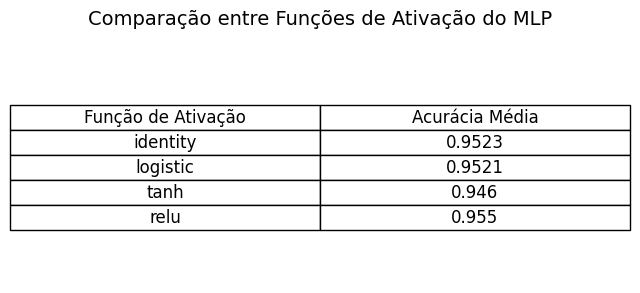

In [26]:
mlp_experiment(X, Y, kf)

<h2>Conclusão</h2>

<p>&nbsp;&nbsp;&nbsp;&nbsp
   As tabelas oferecem uma visão abrangente do desempenho de vários algoritmos de classificação, possibilitando uma análise comparativa robusta.Ao examinarmos as matrizes de confusão em conjunto com os gráficos de desempenho, podemos aprofundar significativamente nossa compreensão dos resultados obtidos em cada experimento. Portanto, ao analisar os resultados gráficos, chegamos às seguinte conclusões:
</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp;
Desempenho Superior de Modelos Baseados em Árvore:

&nbsp;&nbsp;&nbsp;&nbsp; Os algoritmos de Random Forest e Gradient Boosting demonstraram um desempenho consistentemente superior, obtendo as melhores métricas de acurácia e F1-score. Essa superioridade pode ser atribuída à capacidade desses modelos de capturar interações complexas entre as variáveis, construir múltiplas árvores de decisão e combinar suas previsões para obter resultados mais robustos e precisos.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;Estabilidade dos Modelos de Árvore:

&nbsp;&nbsp;&nbsp;&nbsp;Ao variar o número de árvores nos modelos Random Forest e Gradient Boosting, observamos uma estabilidade nos resultados, indicando que esses modelos são relativamente insensíveis a pequenas variações nos hiperparâmetros. 

&nbsp;&nbsp;&nbsp;&nbsp;Desempenho dos Modelos de Árvore de Decisão:

&nbsp;&nbsp;&nbsp;&nbsp;Os modelos de Árvore de Decisão apresentaram um bom desempenho, especialmente com profundidades intermediárias. Aumentar a profundidade da árvore pode levar a overfitting, ou seja, o modelo se ajusta demais aos dados de treinamento e perde a capacidade de generalizar para novos dados.

&nbsp;&nbsp;&nbsp;&nbsp;Desempenho do SVM:

&nbsp;&nbsp;&nbsp;&nbsp;O SVM com kernel linear obteve um bom desempenho, enquanto o SVM com kernel rbf apresentou resultados ligeiramente inferiores. A escolha do kernel adequado é crucial para o desempenho do SVM, pois influencia a forma como os dados são mapeados para um espaço de maior dimensionalidade.

&nbsp;&nbsp;&nbsp;&nbsp;Desempenho do KNN:

&nbsp;&nbsp;&nbsp;&nbsp;O desempenho do KNN foi mais variável, dependendo do valor de k. Valores intermediários de k geralmente levaram a melhores resultados. 

&nbsp;&nbsp;&nbsp;&nbsp;Desempenho dos MLPs:

&nbsp;&nbsp;&nbsp;&nbsp;Os MLPs apresentaram resultados variados dependendo da função de ativação. A ReLU se destacou, seguida da identidade e logistic. A tanh obteve o pior resultado.
</p>

<h3>Matrizes de confusão </h3>

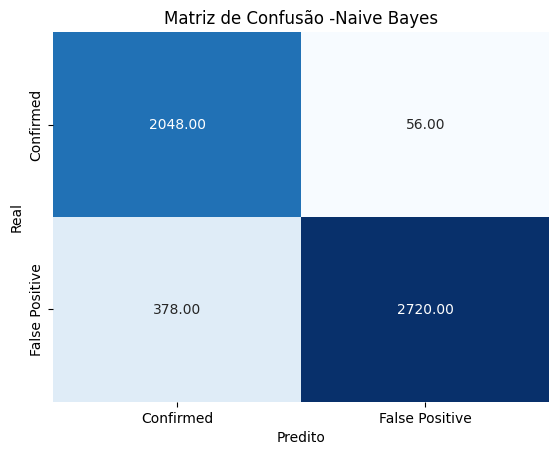

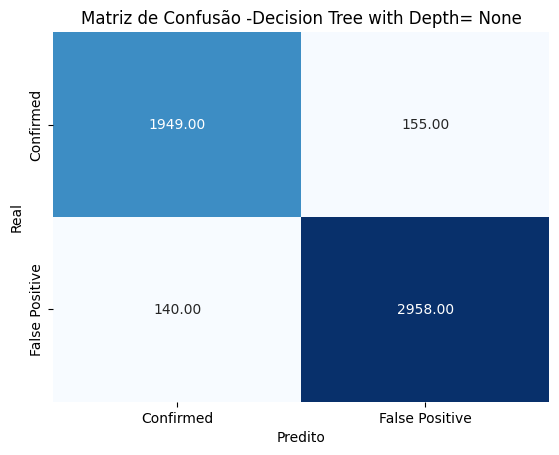

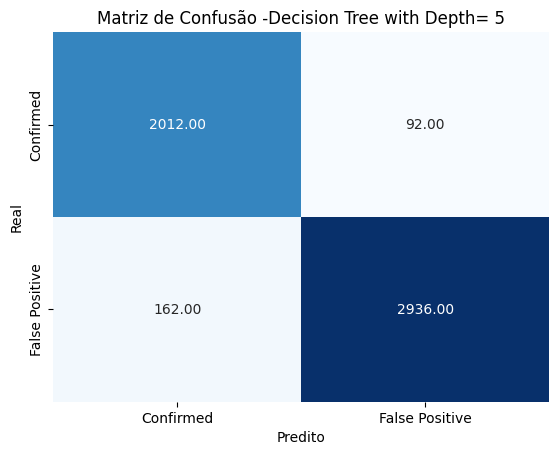

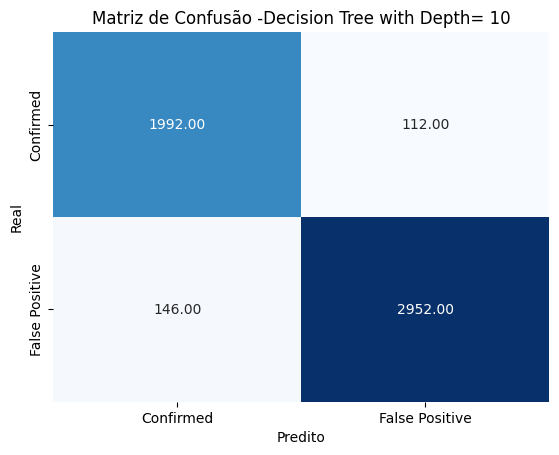

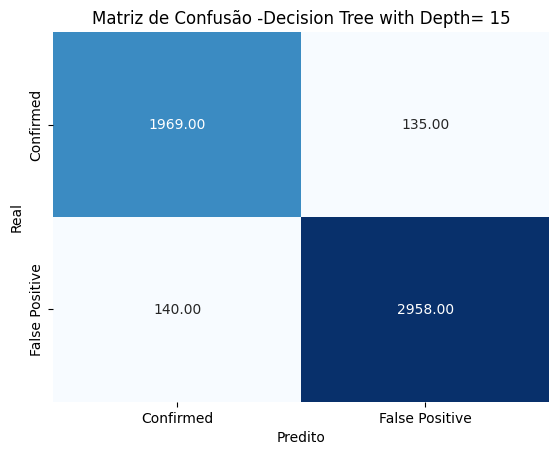

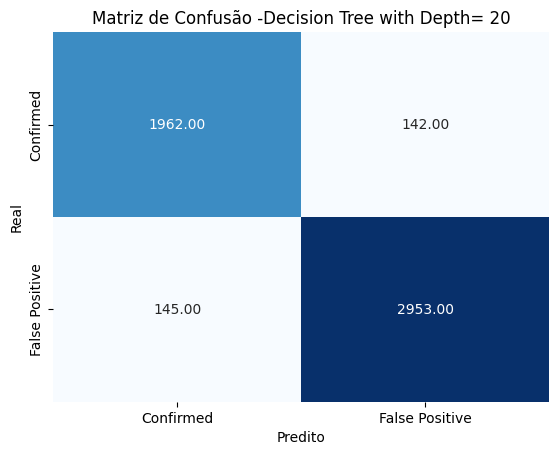

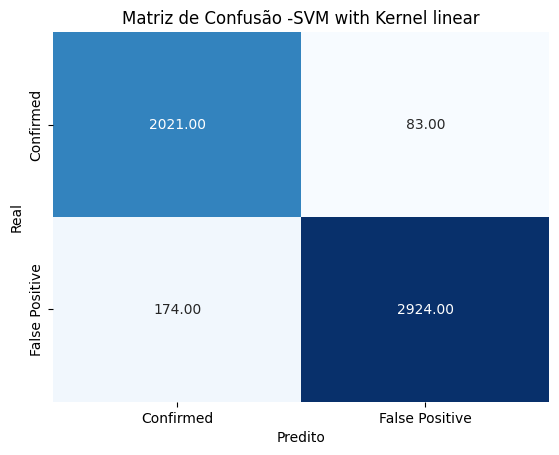

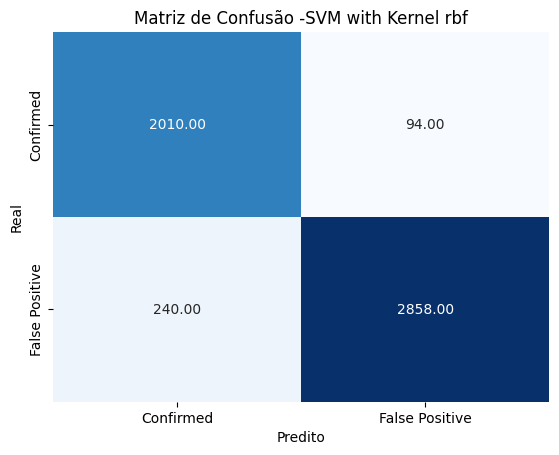

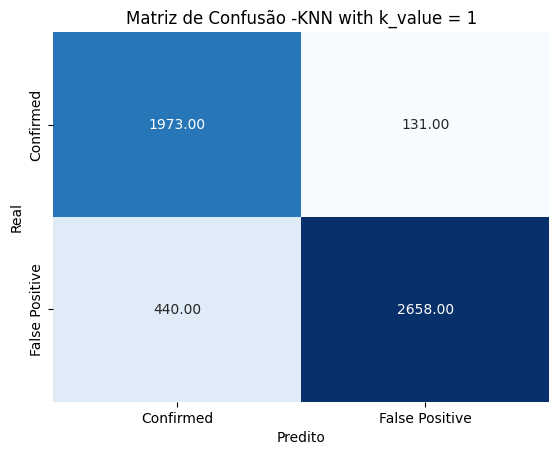

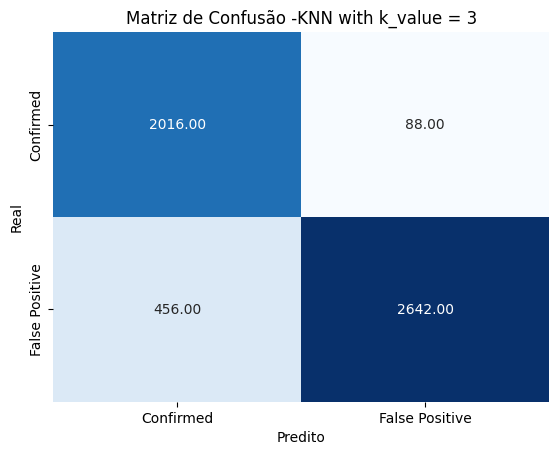

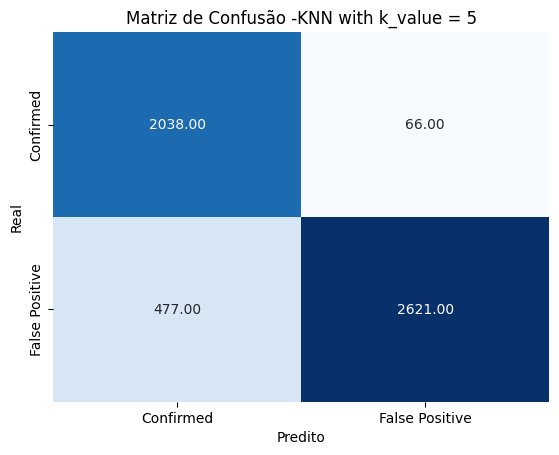

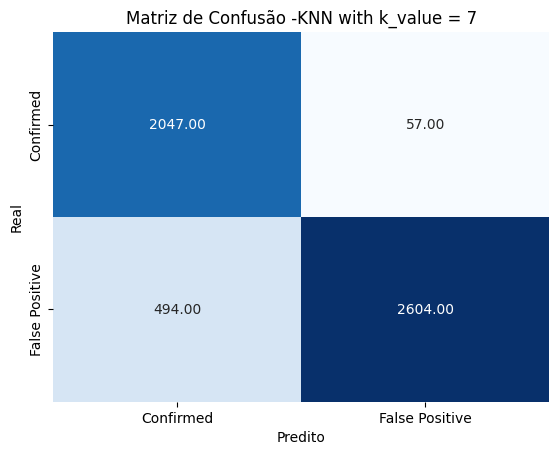

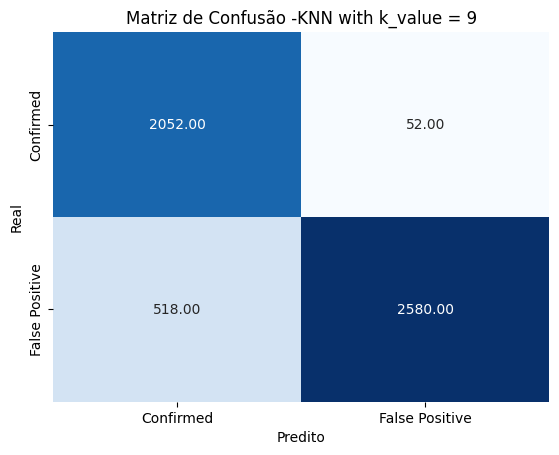

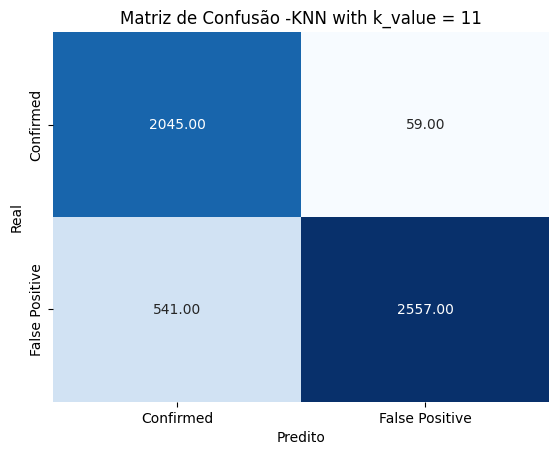

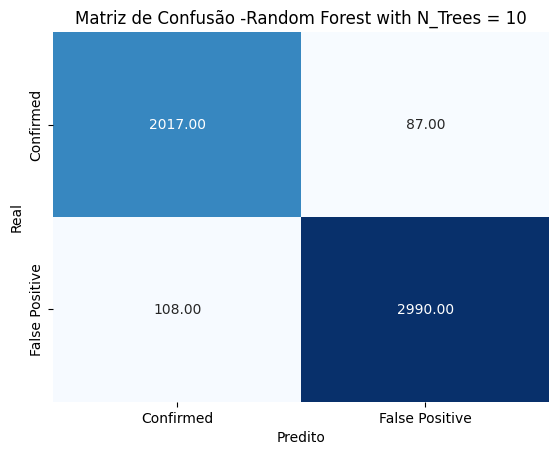

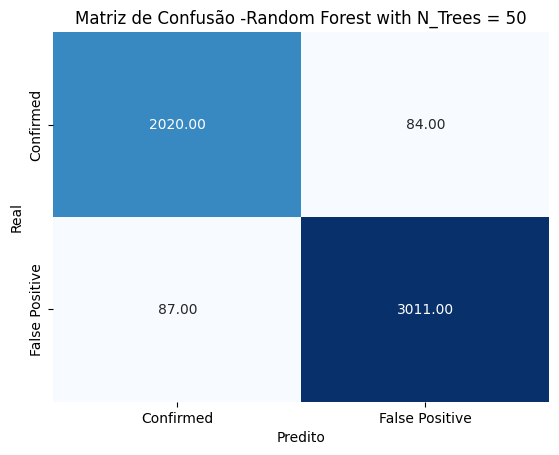

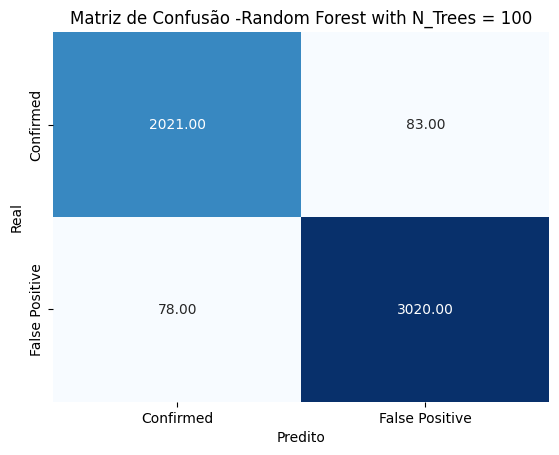

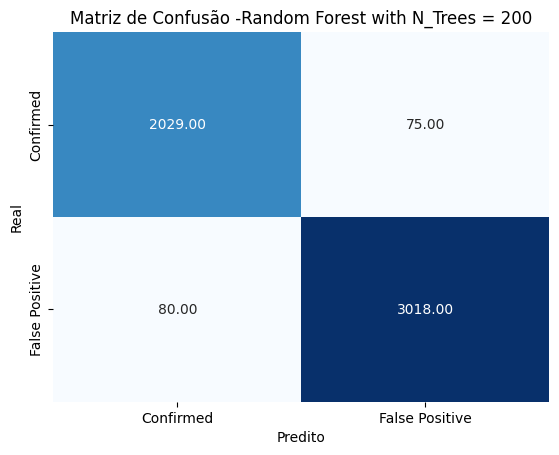

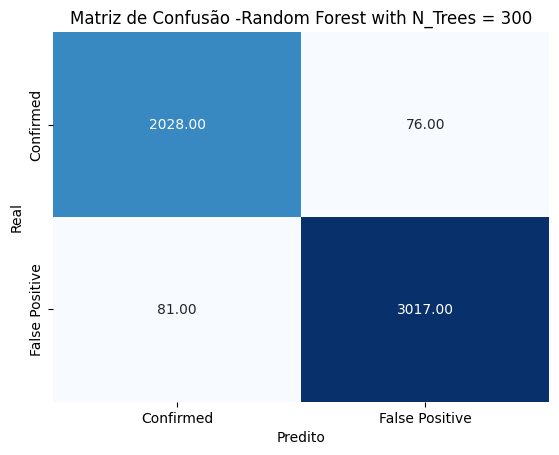

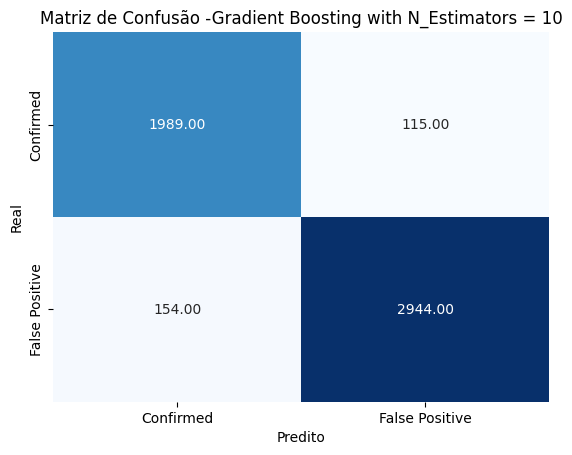

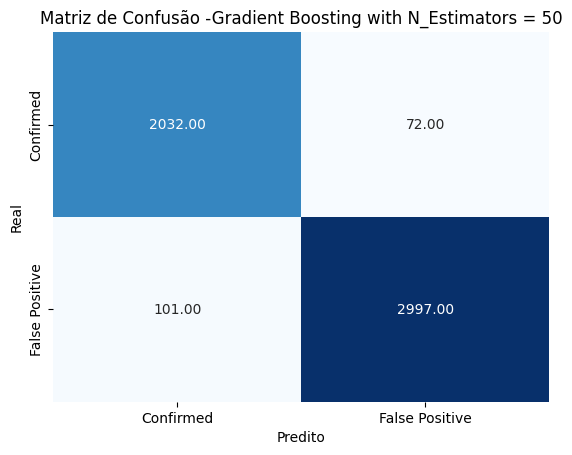

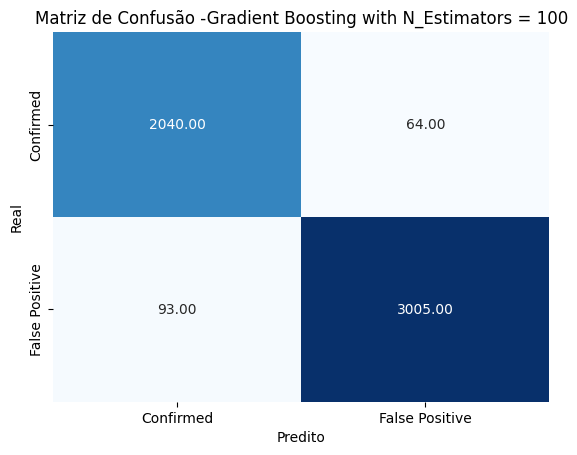

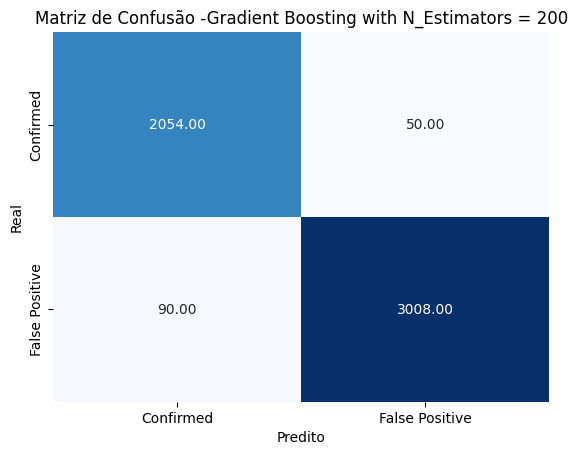

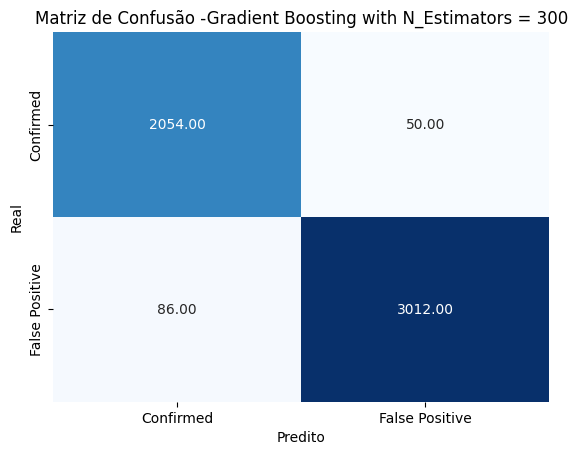

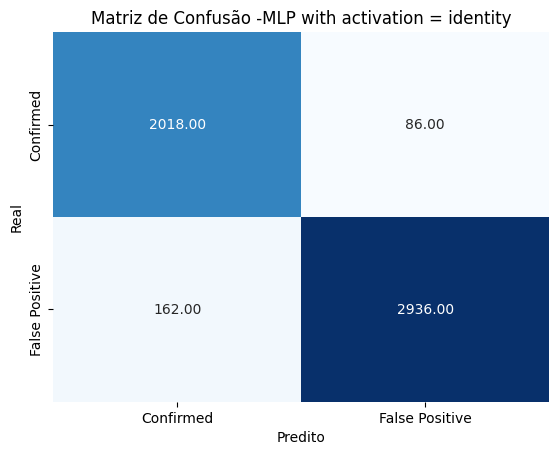

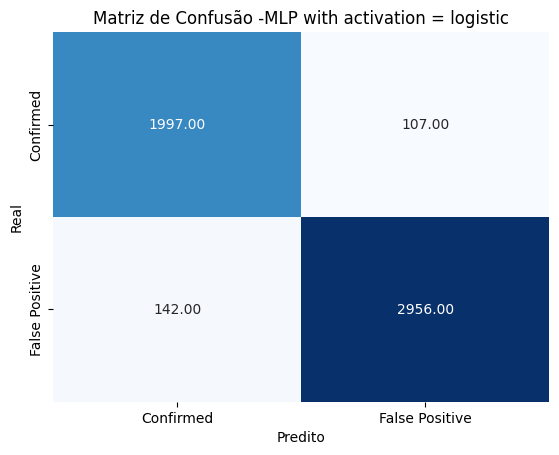

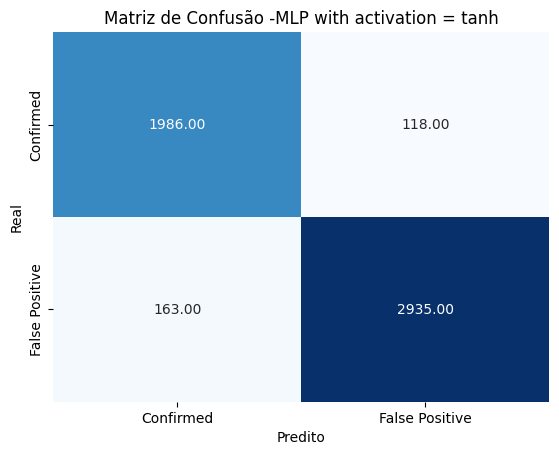

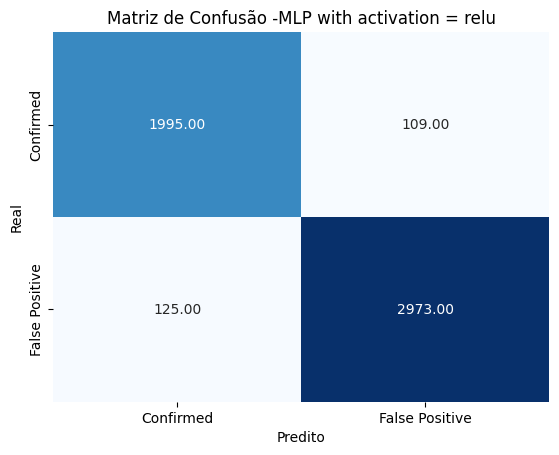

In [80]:
plotAllConfusionmatrix()

In [ ]:
<h3>Gráficos de dis </h3>

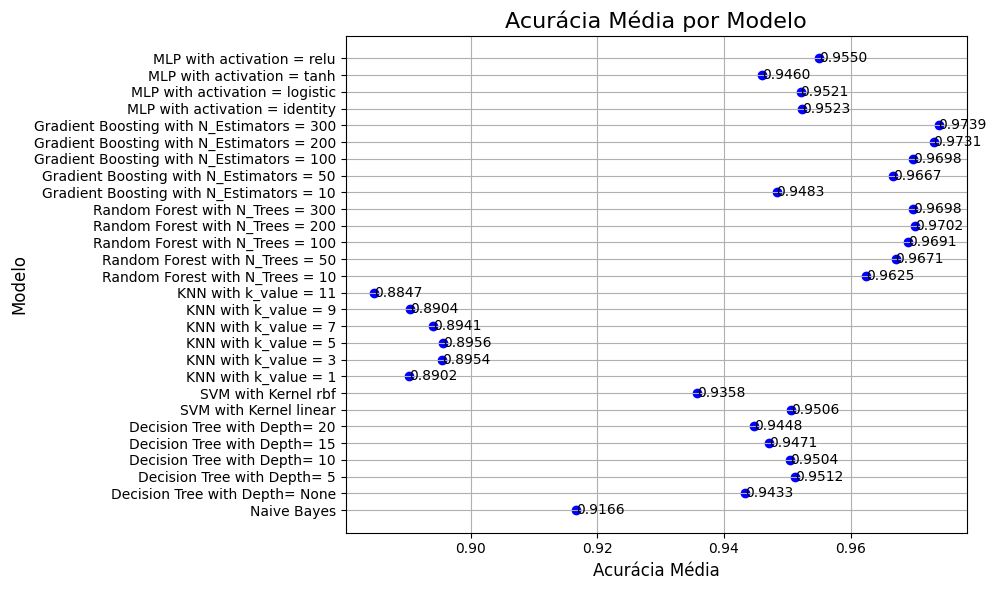

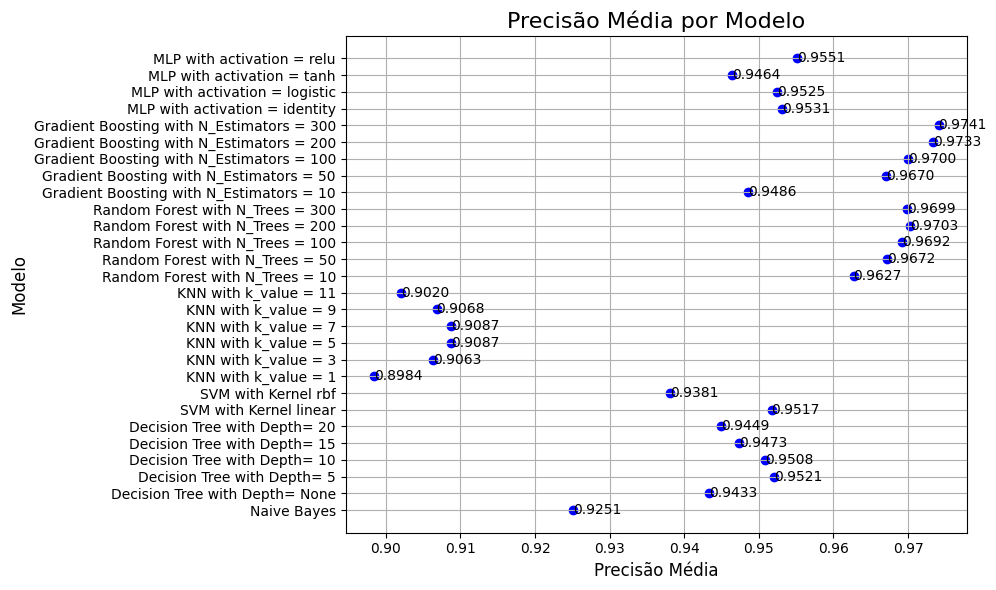

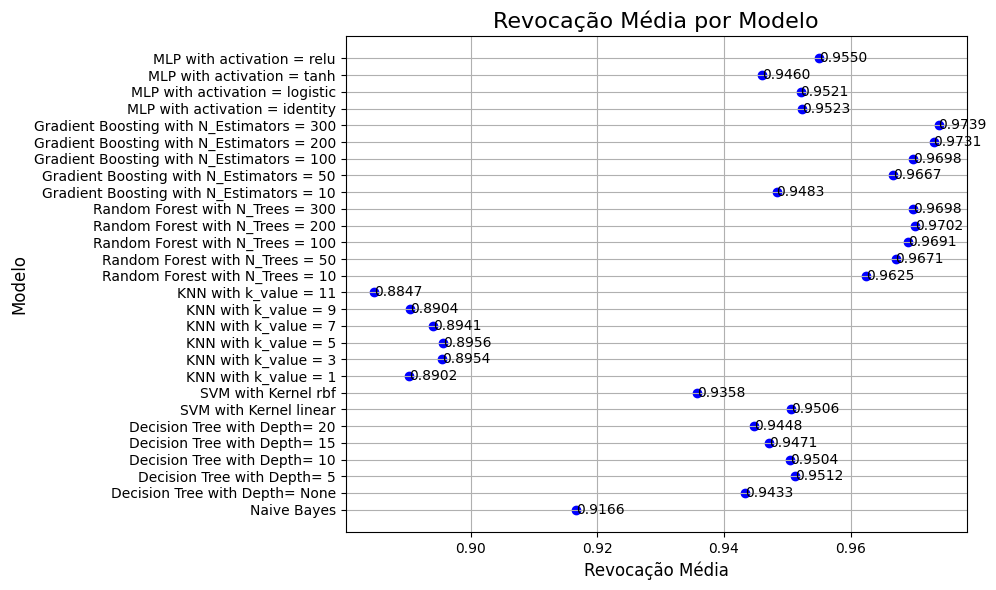

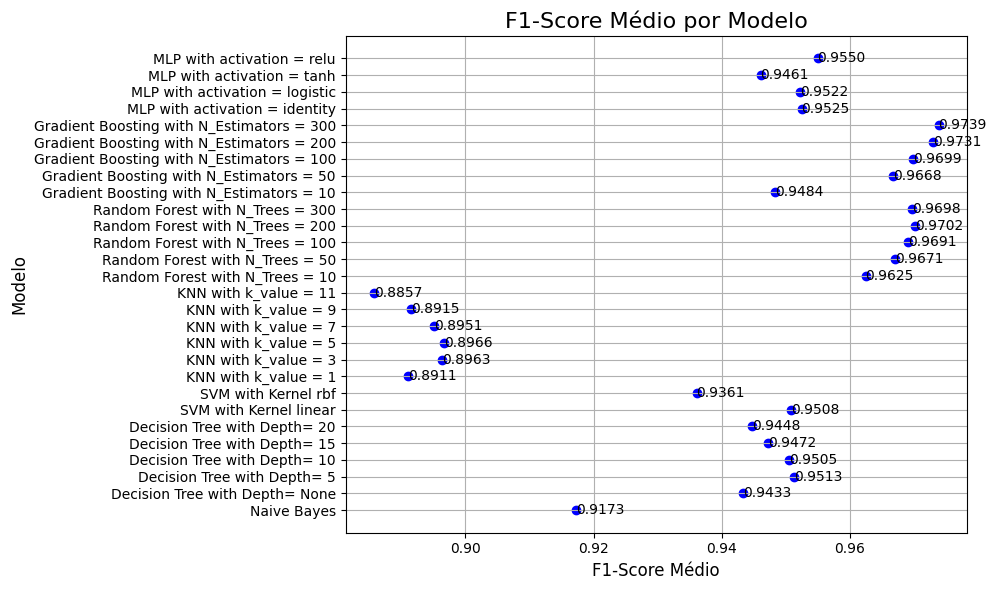

In [28]:
plotAllMetrics()

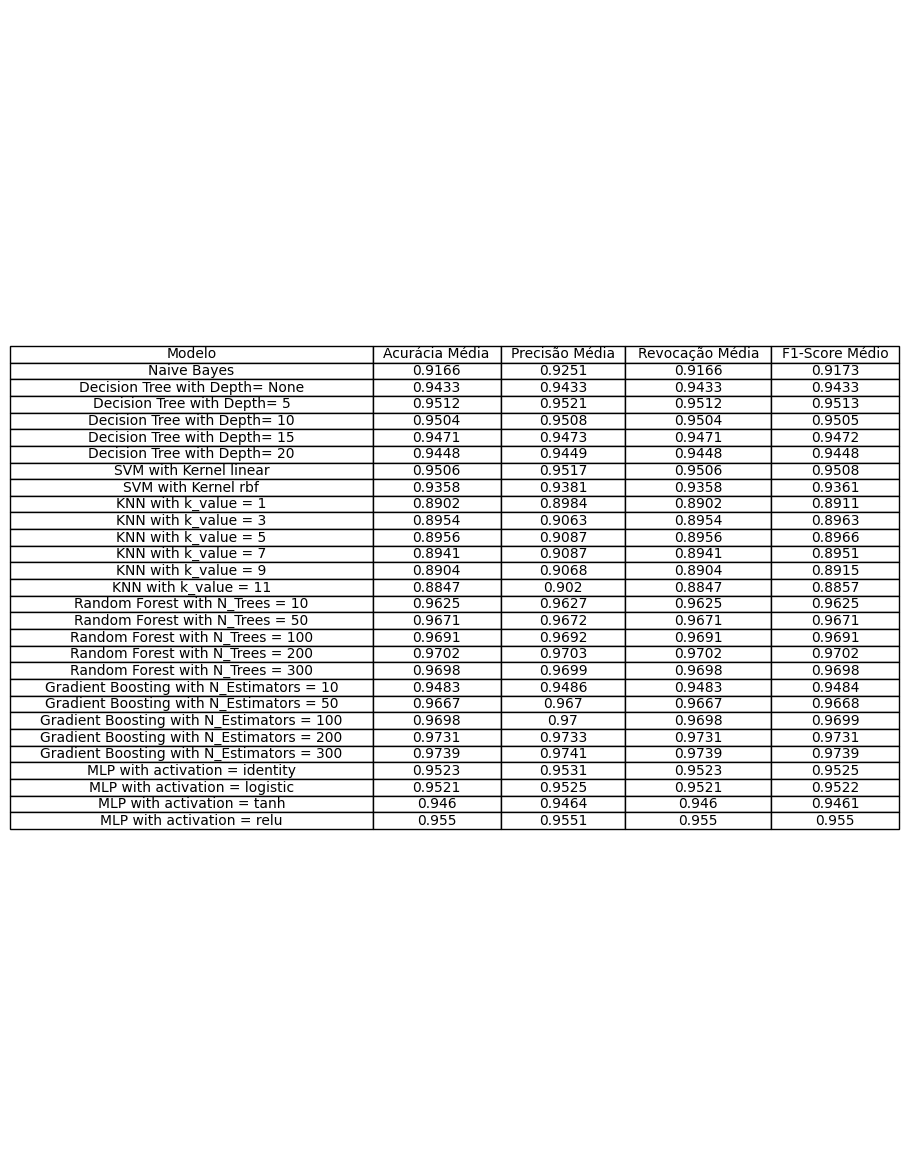

In [29]:
plotAllMetricsTable()